In [1]:
from contextlib import contextmanager
import matplotlib.pyplot as plt
import numpy as np
import corner
import pyvbmc
from nesopy.model import DockerModel
from nesopy.output import read_hdf5_datasets

In this notebook we illustrate an example of using [PyVBMC](https://acerbilab.github.io/pyvbmc/) to infer the posterior on unknown parameters of a probabilistic model based on a plasma physics simulation using the particle-in-cell based solvers implemented in NESO. An important caveat is that here we consider the simulated fields as a deterministic function of the model parameters. In reality the initial states of the particles are sampled using a pseudo-random number generator (PRNG), however we here we fix the seed used to initialise the state of this PRNG to remove this source of stochasticity.

Here we will assume we are only interested in the model outputs corresponding to the electrostatic potential field evaluation along a line, so define a function to extract the one-dimensional arrays of field values and corresponding spatial coordinate.

In [2]:
def extract_outputs(output_directory, completed_process, parameters):
    num_steps = parameters["particle_num_time_steps"]
    final_line_field_step = range(
        0, num_steps, parameters["line_field_deriv_evaluations_step"]
    )[-1]
    return read_hdf5_datasets(
        output_directory / "Electrostatic2D3V_line_field_evaluations.h5part",
        {
            "x": f"Step#{final_line_field_step}/x",
            "field_value": f"Step#{final_line_field_step}/FIELD_EVALUATION_0",
        },
    )

Create a `DockerModel` instance to interface with NESO solvers built on a Docker image, here using the `Electrostatic2D3V` solver with a session (conditions) file corresponding to the 'two stream' example in the main NESO repository

In [3]:
model = DockerModel(
    image_name="neso-on-ubuntu",
    solver_executable_path="/root/NESO/builds/oneapi-dpcpp/solvers/Electrostatic2D3V/Electrostatic2D3V",
    base_session_file_path="session.xml", 
    mesh_file_path="mesh.xml",
    extract_outputs_function=extract_outputs, 
    container_setup_commands=[
        # Set up base Spack environment
        "source /root/.spack/share/spack/setup-env.sh",
        # Activate NESO Spack environment
        "source /root/NESO/activate", 
        # Load Intel OneAPI MPI module to ensure mpirun available
        "spack load intel-oneapi-mpi",
    ],
    num_mpi_processes=4,
    mpirun_options="-map-by core -bind-to hwthread",
)

We assume that our observed data corresponds to the electrostatic potential field values at the final time of the simulation, and so will set parameters governing the steps when outputs are saved to either -1 for outputs we are not using here (field energy trajectory) or so as to save only on final step for output of intetest (line field). The unknown parameters are assumed to be the particle initial velocity, particle charge density and particle number density, with independent uniform priors placed on all three. The observations are assumed to be subject to independent additive Gaussian noise with standard deviation 0.1. We generate the field values used to simulate the observations with a set of fixed 'true' parameter values. 

In [4]:
num_step = 1800

data = {
    "fixed_parameters": {
        "particle_num_time_steps": num_step + 1,
        "line_field_deriv_evaluations_step": num_step,
        "num_particles_total": 400_000,
        "particle_num_write_field_energy_steps": -1,
        "particle_num_print_steps": -1,
    },
    "charge_density_prior_interval": (0., 200.),
    "number_density_prior_interval": (0., 200.),
    "velocity_prior_interval": (0., 2.),
    "observation_noise_std": 0.1,
    "seed": 8017293,
}

true_parameters = {"particle_initial_velocity": 0.96, "particle_charge_density": 99., "particle_number_density": 103.}

Call the model object to generate the true field values that will be used to simulate the observations.

In [5]:
%%time
true_field = model(**true_parameters, **data["fixed_parameters"])

CPU times: user 11.1 ms, sys: 600 µs, total: 11.7 ms
Wall time: 1min 35s


Simulate noisy observations by perturbing the true field values with independent Gaussian noise with a specified standard deviation.

In [6]:
rng = np.random.default_rng(data["seed"])
data["observed_field"] = true_field["field_value"] + rng.standard_normal(true_field["field_value"].shape[0]) * data["observation_noise_std"]

Plot the smooth true electrostatic potential field along line and noisy observations we will use for inferring posterior on unknown parameters.

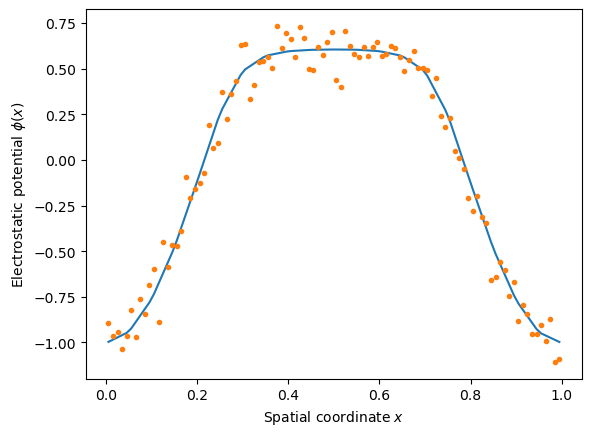

In [7]:
fig, ax = plt.subplots()
ax.plot(true_field["x"], true_field["field_value"], label="True field")
ax.plot(true_field["x"], data["observed_field"], '.', label="Observations")
_ = ax.set(xlabel="Spatial coordinate $x$", ylabel="Electrostatic potential $\phi(x)$")

The main object required by PyVBMC to infer an approximate posterior is a function for computing pointwise evaluations of the logarithm of the joint density on the observed variables and unknown parameters (corresponding to the unnormalized log posterior density when considered as a function of the parameters only for fixed observed data). In our case as we are assuming uniform prior distributions on the parameters, within the support of the prior distribution the log joint density consists only a term for the Gaussian likelihood plus a constant term corresponding to the uniform prior density which we can ignore. PyVBMC internally deals with ensuring the log density function is only evaluated at points within the support of the prior / posterior, so we do not need to separately add indicator function terms to ensure the density evaluates to zero outside the support of the distribution.

In [8]:
def log_joint_density(theta, data):
    parameters = {"particle_initial_velocity": theta[0], "particle_charge_density": theta[1], "particle_number_density": theta[2]}
    generated_field = model(**parameters, **data["fixed_parameters"])
    return -((data["observed_field"] - generated_field["field_value"])**2 / (2 * data["observation_noise_std"]**2)).sum()

PyVBMC also requires us to define the (potentially infinite) bounds of a hypercube on which the posterior and prior distributions have support --- here we use the intervals over which the uniform priors are defined to set these bounds. 'Plausible' lower and upper bounds for the parameters are also required, which should correspond to a hypercube of _finite_ extent which we believe to contain a region of high posterior probability mass, with this being used to select the initial points in the parameter space to sample and set hyperparameters of the algorithm. The final approximated posterior will not be limited to having support on this plausible region, but setting this region sensibly is important to getting good performance from the algorithm. Here we use a coarse assumption that the plausible region is the product of the intervals covering the central 50% of the prior intervals. For the three dimensional problem here this corresponds to a region containing only a eighth of the overall prior mass - while this appears to work for this case, ideally this would instead be set more intelligently based on domain expertise. We can also optionally specify an initial point in the parameter space which we here sample uniformly from the plausible region. The PyVBMC `VBMC` (variational Bayesian Monte Carlo) object assumes the passed log density function has only one argument corresponding to the vector of parameters so we close over the data here using an anonymous function. We also specify for the `VBMC` object to plot the intermediate posterior approximations while fitting.

The main method of interest of the resulting `VBMC` object is `VBMC.optimize` which fits the posterior approximation, returning a `VariationalPosterior` object and dictionary of intermediate results from the optimization.

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        -486.58       341.20          inf        2        inf     start warm-up


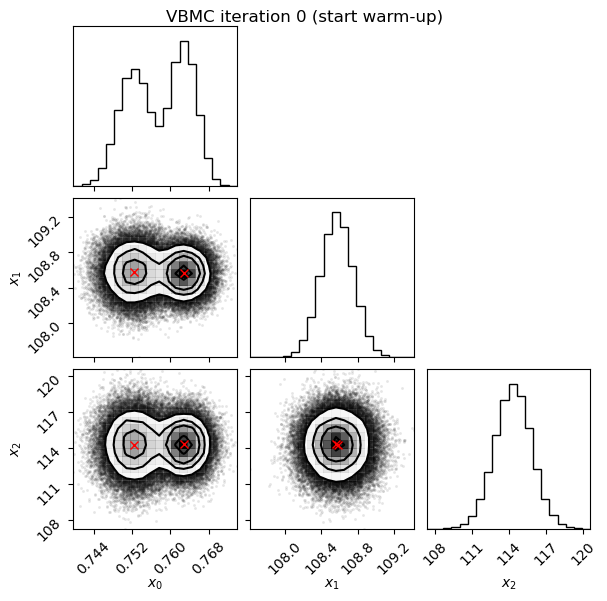

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     1         15        -254.13        35.96        43.71        2        inf     


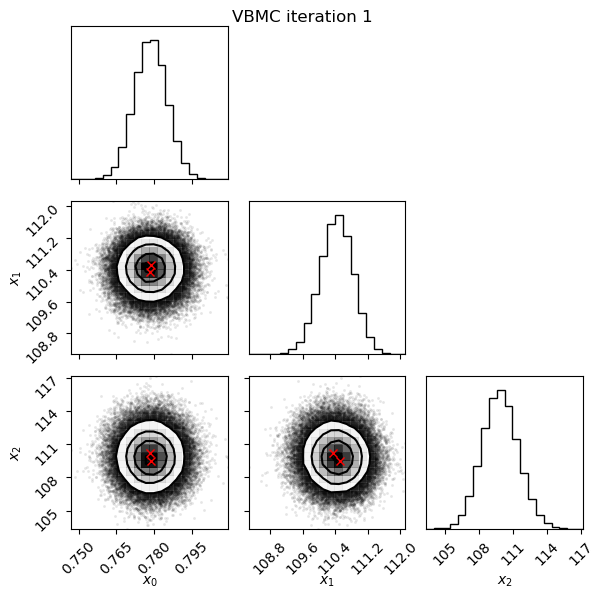

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     2         20         -35.67        57.76       332.90        2   7.33e+03     


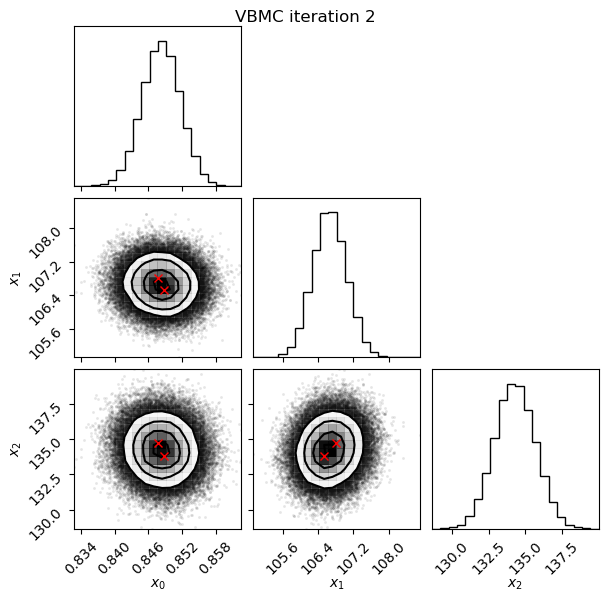

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     3         25          13.50       121.22       394.68        2   8.16e+03     


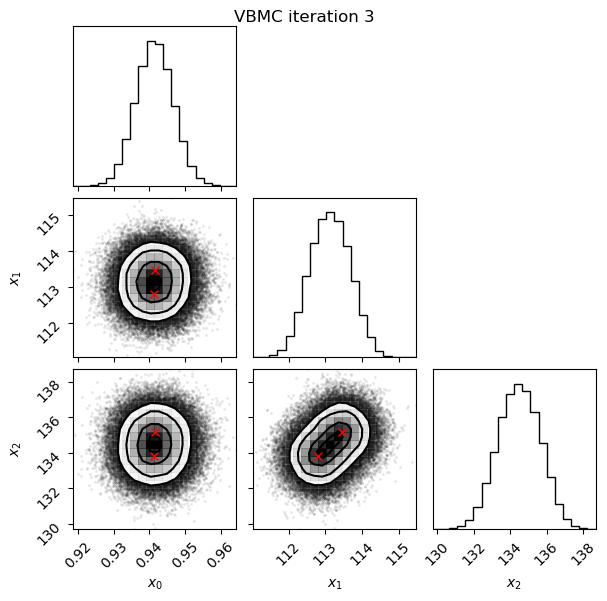

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     4         30         -29.58        79.00       183.89        2   3.95e+03     


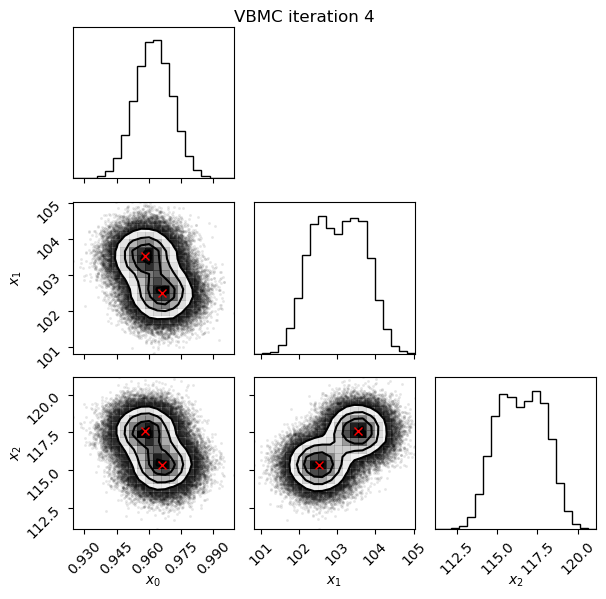

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     5         35         -38.77         0.87        25.00        2        515     


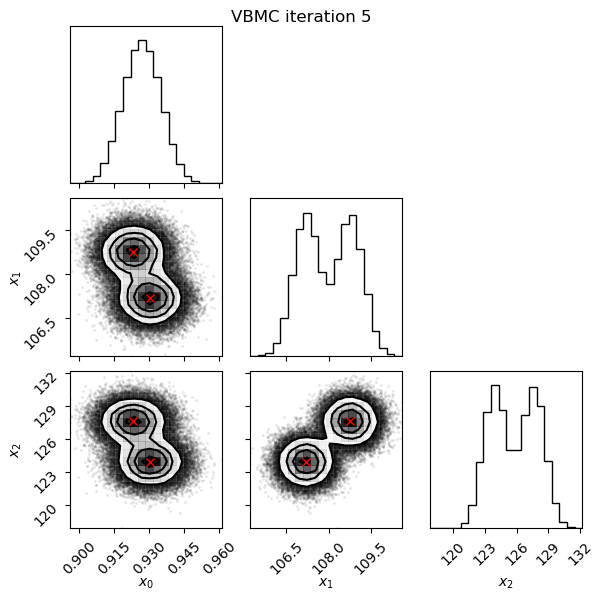

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     6         40         -31.26        14.40        91.25        2   1.83e+03     


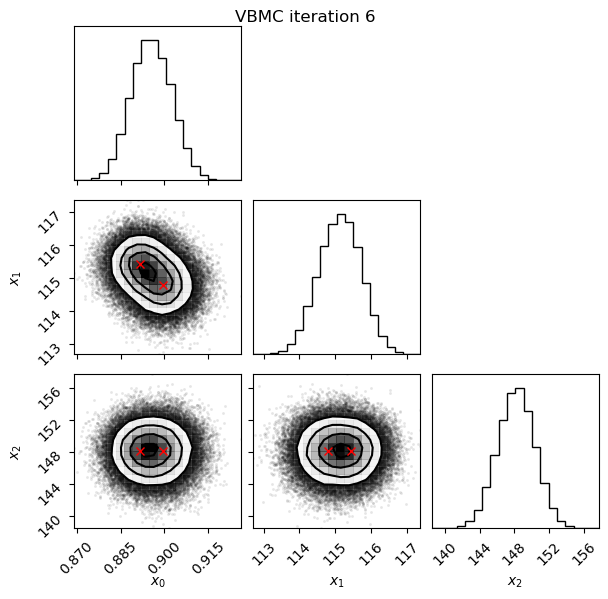

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     7         45         -38.62         0.66         9.81        2        216     


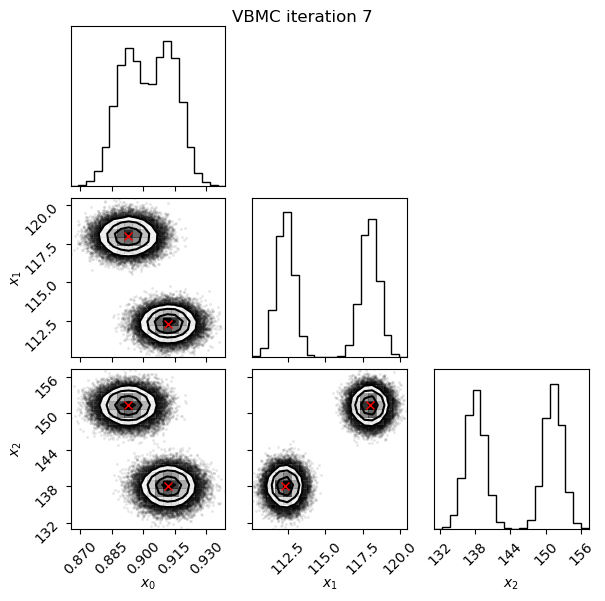

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     8         50         -39.29         0.04         1.04        2       22.3     


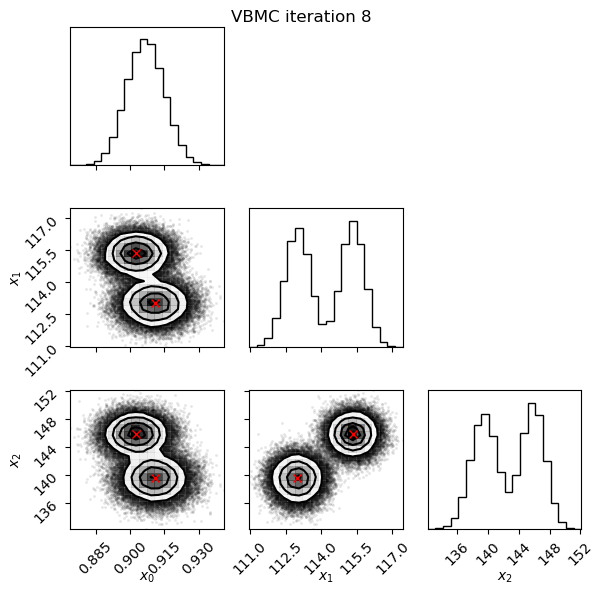

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     9         55         -39.32         0.01         0.20        2       4.03     


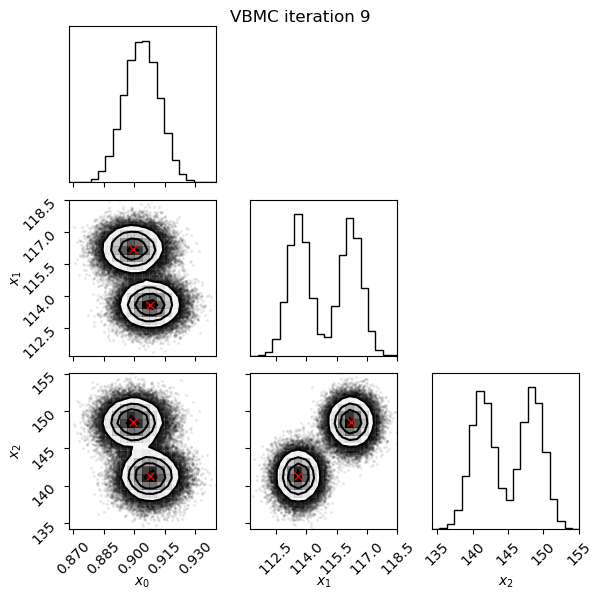

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    10         60         -39.35         0.01         0.17        2       3.45     


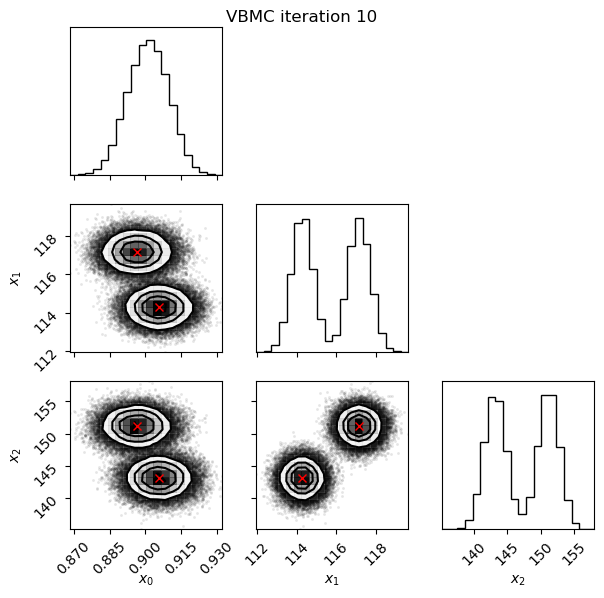

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    11         65         -39.35         0.00         0.02        2      0.401     end warm-up


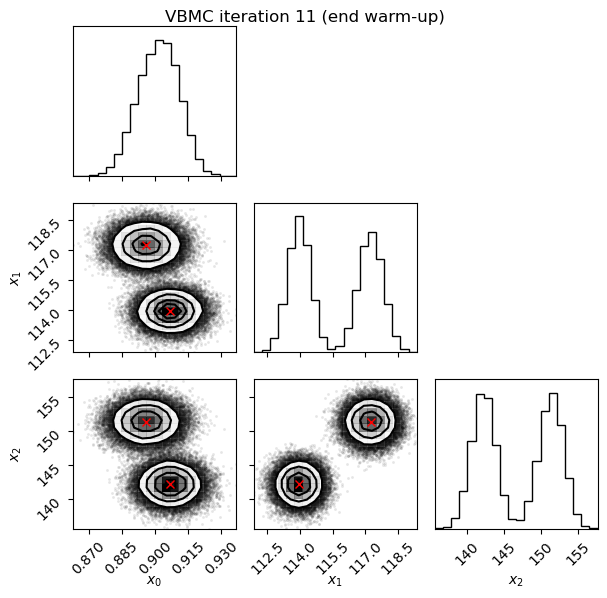

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    12         70         -39.33         0.00         0.02        2      0.477     


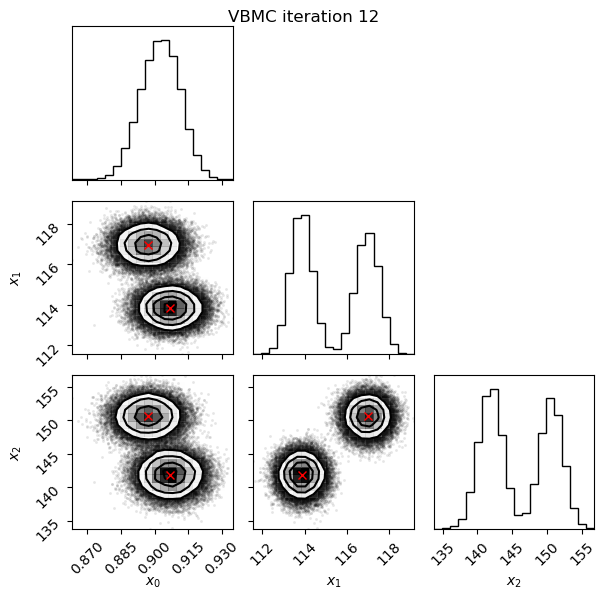

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    13         75         -39.33         0.00         0.01        2      0.123     


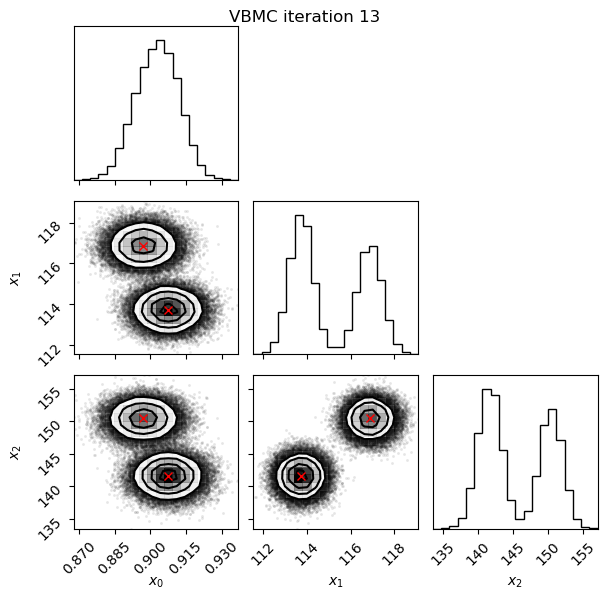

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    14         80         -38.59         0.00         0.21        5       6.57     


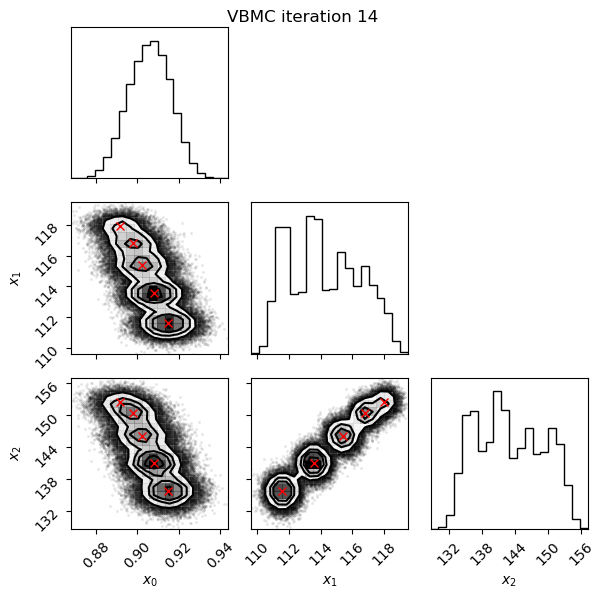

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    15         85         -38.47         0.00         0.02        6      0.708     


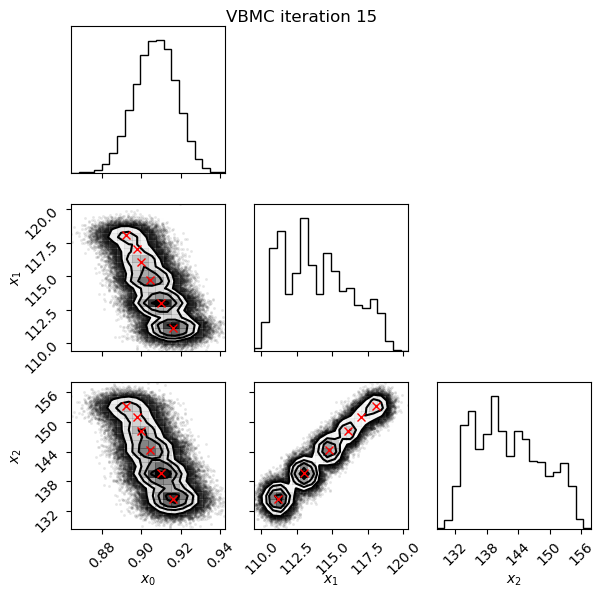

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    16         85         -37.25         0.04         1.76        7         38     rotoscale


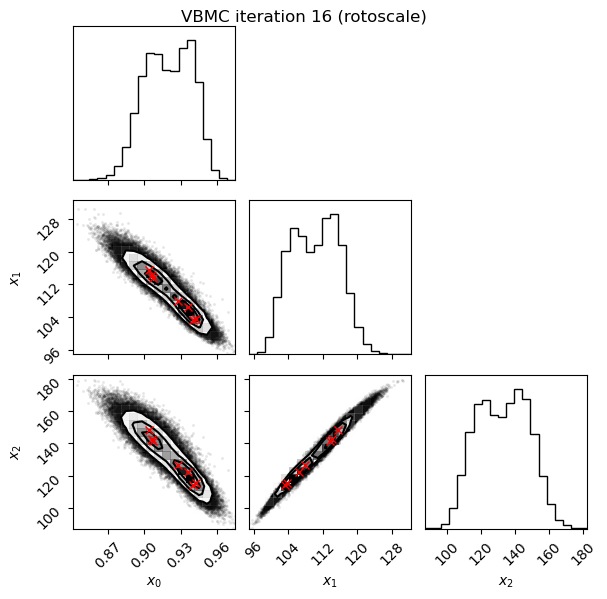

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    17         90         -37.21         0.00         0.01        8      0.411     


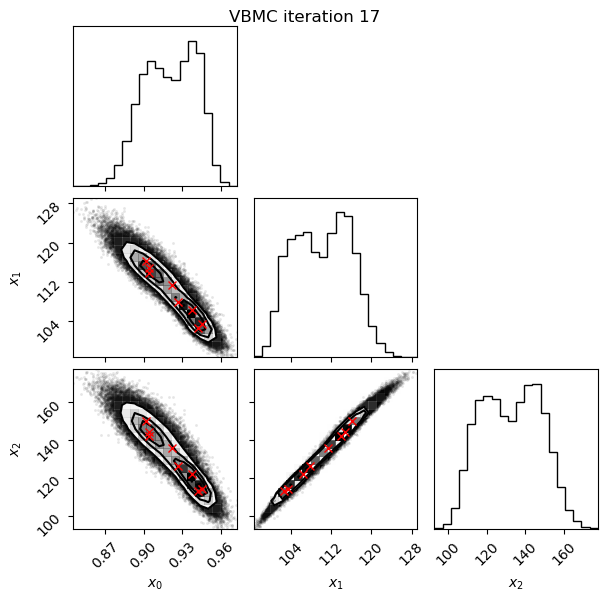

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    18         95         -37.12         0.00         0.02       11      0.629     


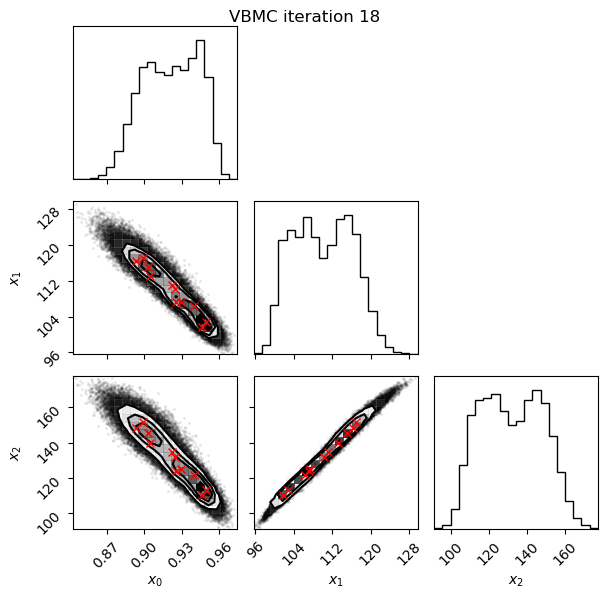

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    19        100         -36.99         0.00         0.01       14      0.649     


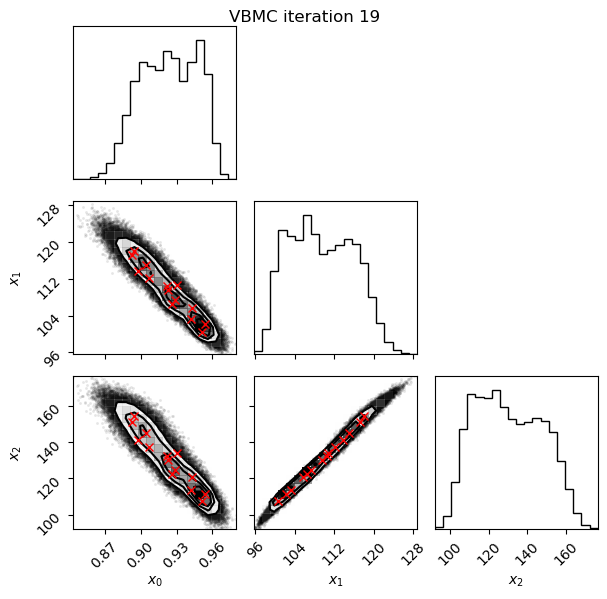

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    20        105         -36.93         0.00         0.01       17      0.338     


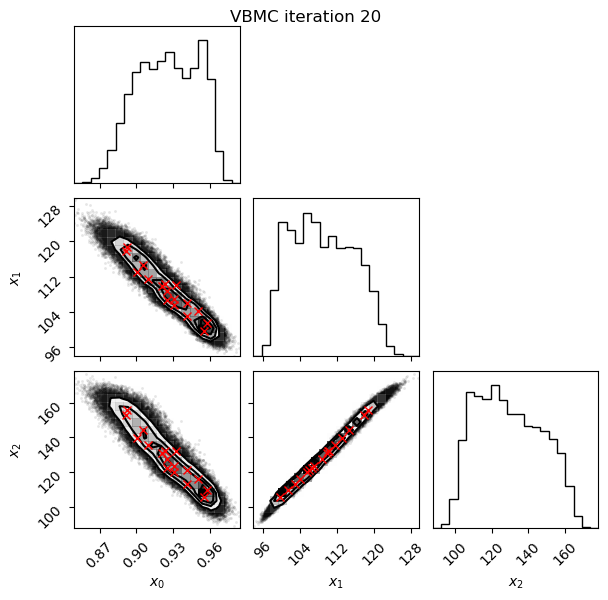

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    21        110         -36.90         0.00         0.00       19       0.14     


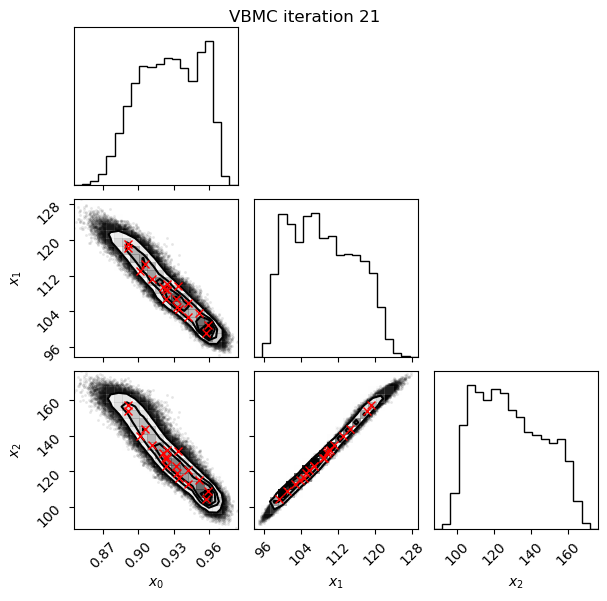

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    22        110         -36.74         0.00         0.07       18       1.83     rotoscale


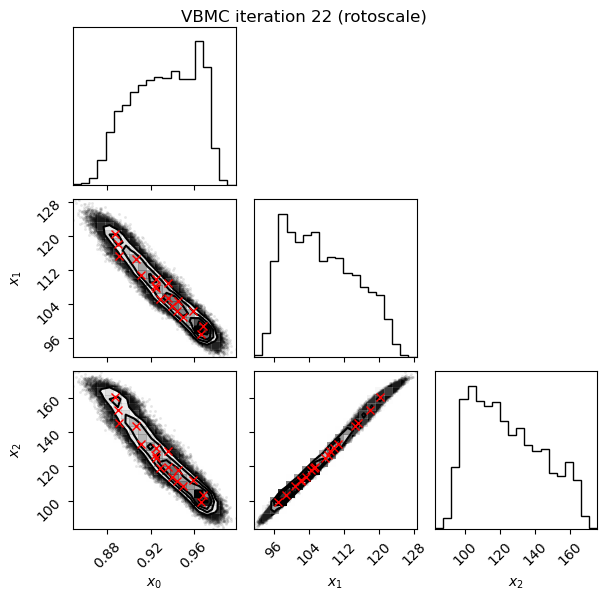

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    23        115         -36.72         0.00         0.00       18      0.135     


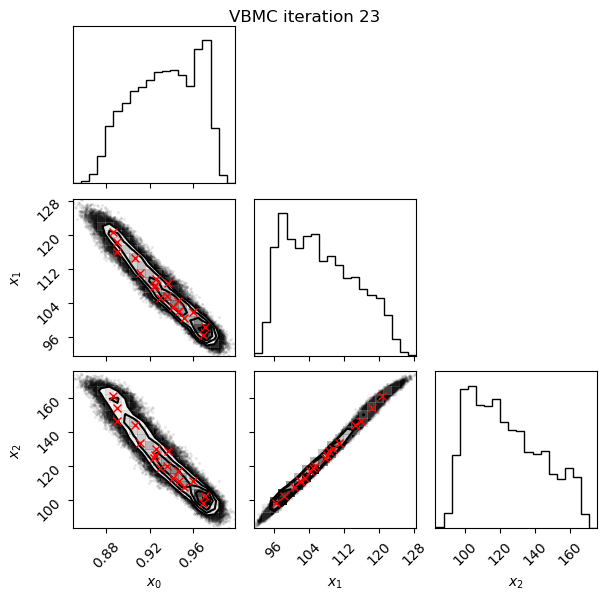

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    24        120         -36.68         0.00         0.00       19      0.169     


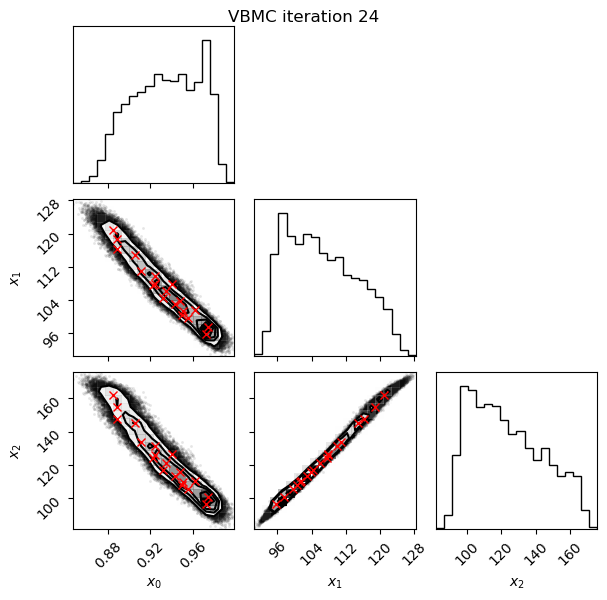

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    25        125         -36.67         0.00         0.00       18     0.0916     


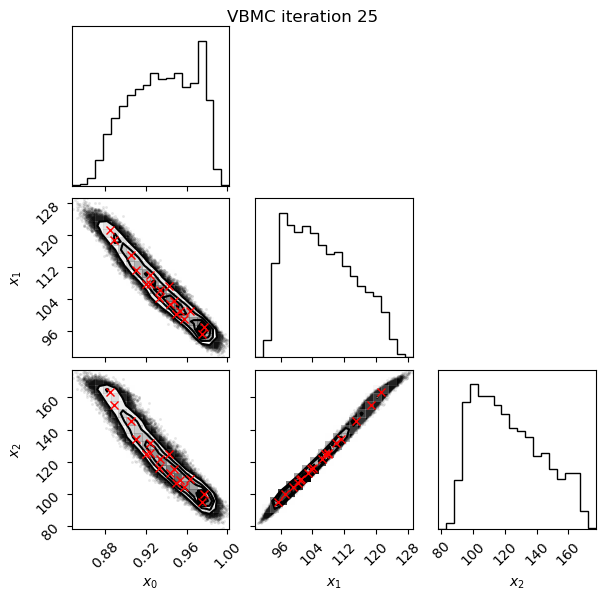

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
    26        130         -36.64         0.00         0.00       18      0.126     stable


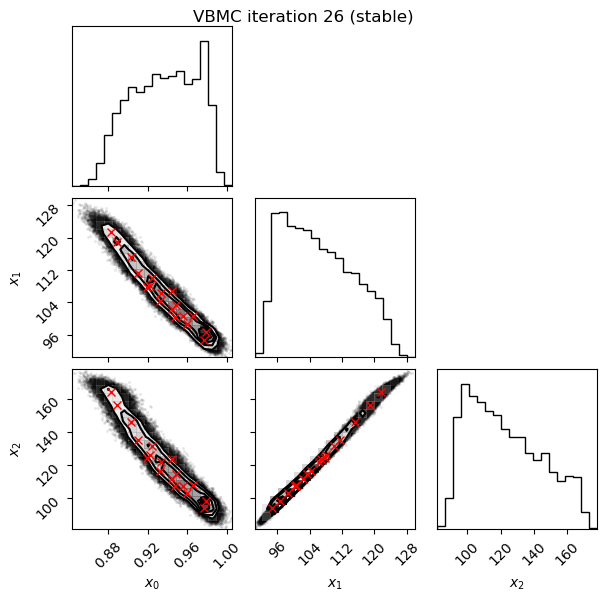

 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
   inf        130         -36.48         0.00         0.05       50      0.126     finalize


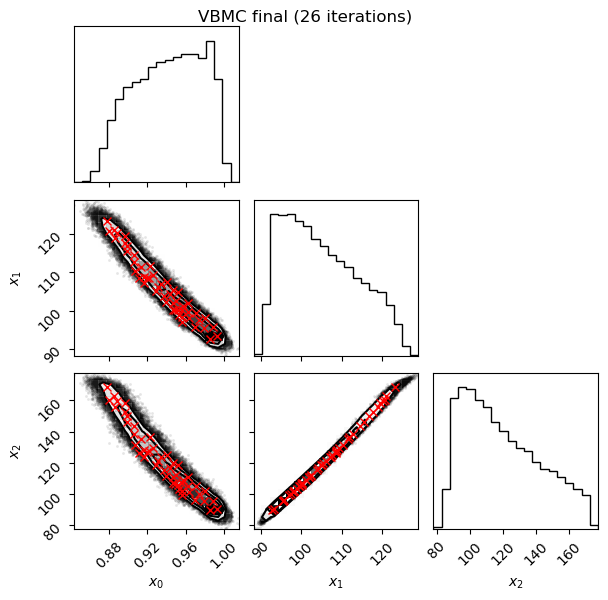

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -36.477 +/-0.002.


In [9]:
lower_bounds = np.array(
    (data["velocity_prior_interval"][0], data["charge_density_prior_interval"][0], data["number_density_prior_interval"][0])
)
upper_bounds = np.array(
    (data["velocity_prior_interval"][1], data["charge_density_prior_interval"][1], data["number_density_prior_interval"][1])
)
plausible_lower_bounds =  lower_bounds + (upper_bounds - lower_bounds) / 4
plausible_upper_bounds =  upper_bounds - (upper_bounds - lower_bounds) / 4
theta_0 = rng.uniform(plausible_lower_bounds, plausible_upper_bounds)
np.random.seed(data["seed"])
vbmc = pyvbmc.VBMC(
    lambda theta: log_joint_density(theta, data),
    theta_0,
    lower_bounds,
    upper_bounds,
    plausible_lower_bounds,
    plausible_upper_bounds,
    options={"plot": True},
)
vp, results = vbmc.optimize()

We can use the fitted variational posterior object `vp` in various ways, including evaluating its log probability density function, computing moments and sampling parameter values from the approximated posterior. Here we sample parameter values from the final fitted variational posterior and visualize the pairwise marginals as a [corner plot](https://corner.readthedocs.io/en/latest/), also showing the true parameter values used to generate the simulated data to verify these are plausible samples from the posterior distribution (which would be expected if the overall inference procedure is calibrated).

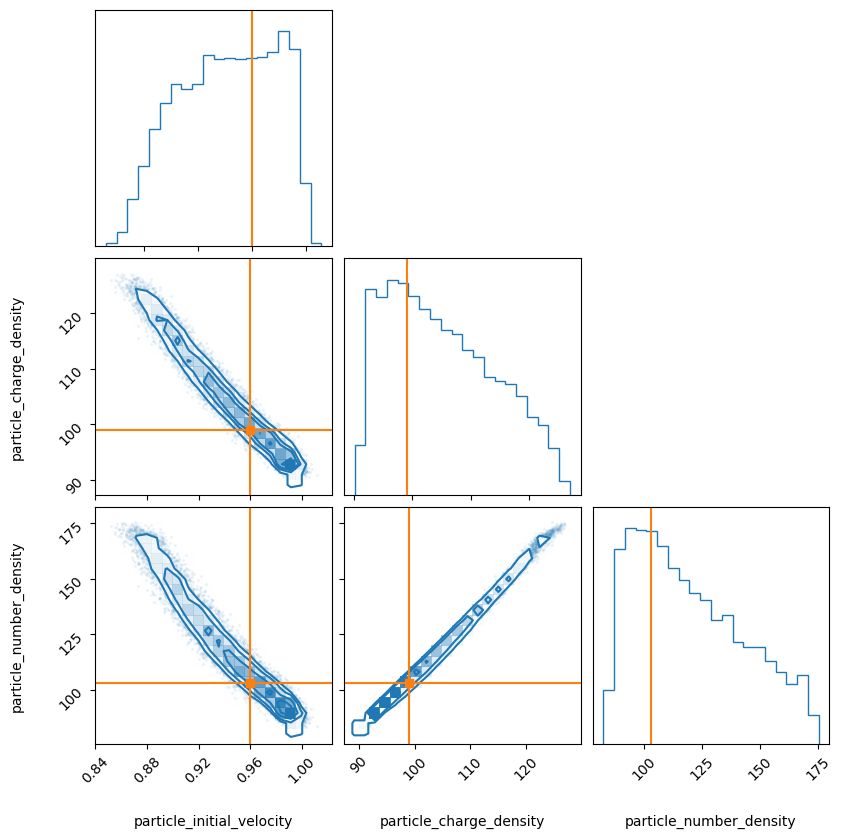

In [12]:
theta_samples, _ = vp.sample(10000)
fig, axes = plt.subplots(theta_samples.shape[1], theta_samples.shape[1], figsize=(9, 9), dpi=100)
corner.corner(
    data=theta_samples,
    labels=list(true_parameters.keys()),
    smooth=0.25,
    truths=list(true_parameters.values()),
    color="C0",
    truth_color="C1",
    fig=fig,
);

We can also plot the variational posterior directly as a corner plot using the `VariationalPosterior.plot` method, which additionally allows us to plot the actively sampled points in the parameter space used to fit the Gaussian process model of the log joint density used for fitting the variational posterior.

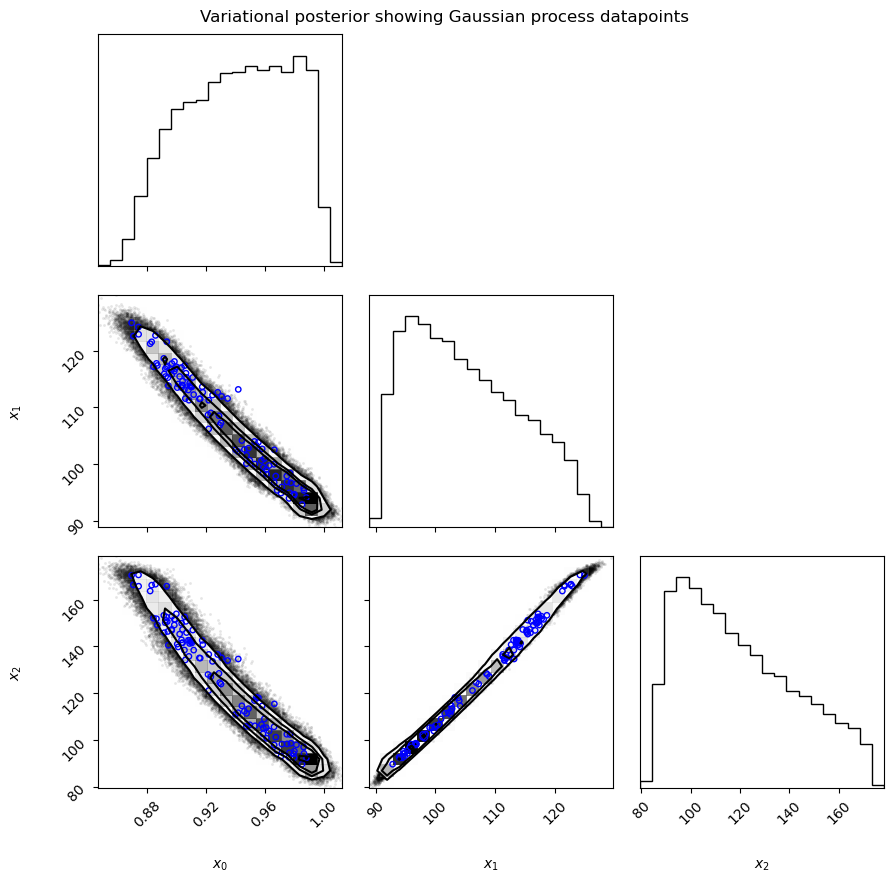

In [18]:
fig = vp.plot(title="Variational posterior showing Gaussian process datapoints", gp=vbmc.gp, plot_data=True)
fig.set(size_inches=(9, 9), dpi=100);